<a href="https://colab.research.google.com/github/Monoxido45/Active_learning_tests/blob/master/modules/active_learning_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Exemplos simples de Active learning:** 



*   Primeiramente iremos usar o banco de dados iris, para uma pequena pratica:



In [1]:
# pacotes importados
import numpy as np
import pandas as pd

# para os graficos
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

# PCA e os dados de interesse
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

Antes de realizar o active learning para o exemplo do iris, podemos explorar o banco de dados:

In [2]:
# importando o IRIS
iris = load_iris()

# transformando o objeto iris em um data frame pandas
iris_data = pd.DataFrame(data = np.c_[iris['data'], iris['target']],
                         columns = iris['feature_names'] + ['target'])


# vendo apenas as 10 primeiras observacoes
iris_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


Primeiramente, podemos fazer uma matriz de gráfico de dispersão

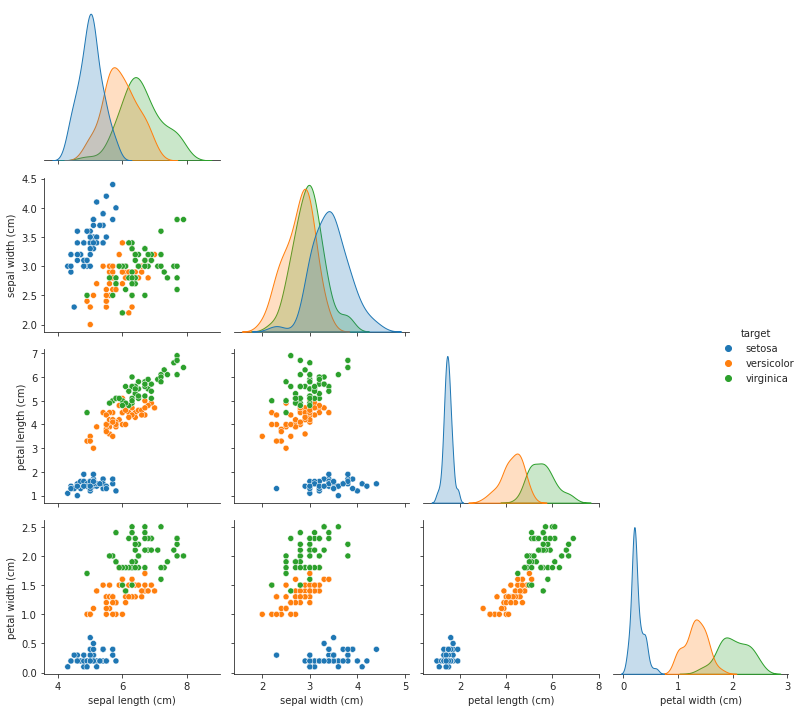

In [3]:
# dados para a analise descritiva
iris_desc = iris_data.copy()

replace_data = {"target" : {0.0: iris['target_names'][0],
                            1.0: iris['target_names'][1],
                            2.0: iris['target_names'][2]}}

iris_desc = iris_desc.replace(replace_data)
sns.set_style("ticks")

sns.pairplot(iris_desc, hue = "target", corner=True)
plt.tight_layout()

Além disso, também podemos fazer uma matriz de correlação:

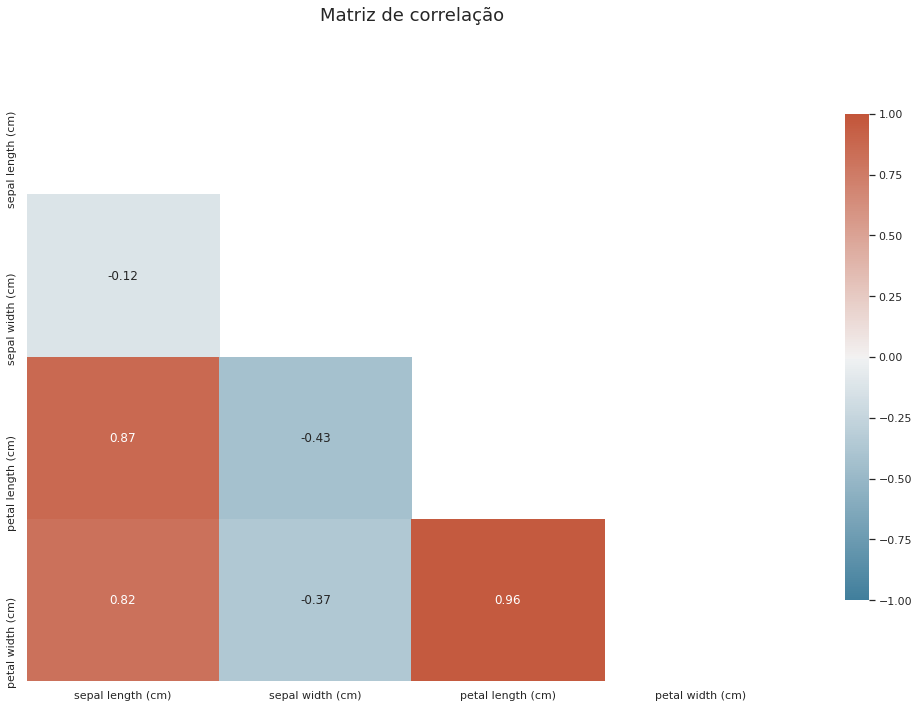

In [4]:
sns.set_theme(style="white")

# fazendo a matriz de correlacao usando mascaras
corr = iris_desc.corr()
mask = np.triu(np.ones_like(corr))

# figura do matplotlib
f, ax = plt.subplots(figsize=(14, 10))

# palheta customizada
cmap = sns.diverging_palette(230, 20, as_cmap = True)

heatmap = sns.heatmap(corr, mask=mask, vmax= 1, vmin = -1, cmap = cmap, cbar_kws={"shrink": .75}, annot = True)
heatmap.set_title('Matriz de correlação', fontdict={'fontsize':18}, pad=12)
plt.tight_layout()

E por fim alguns violinplots separados:

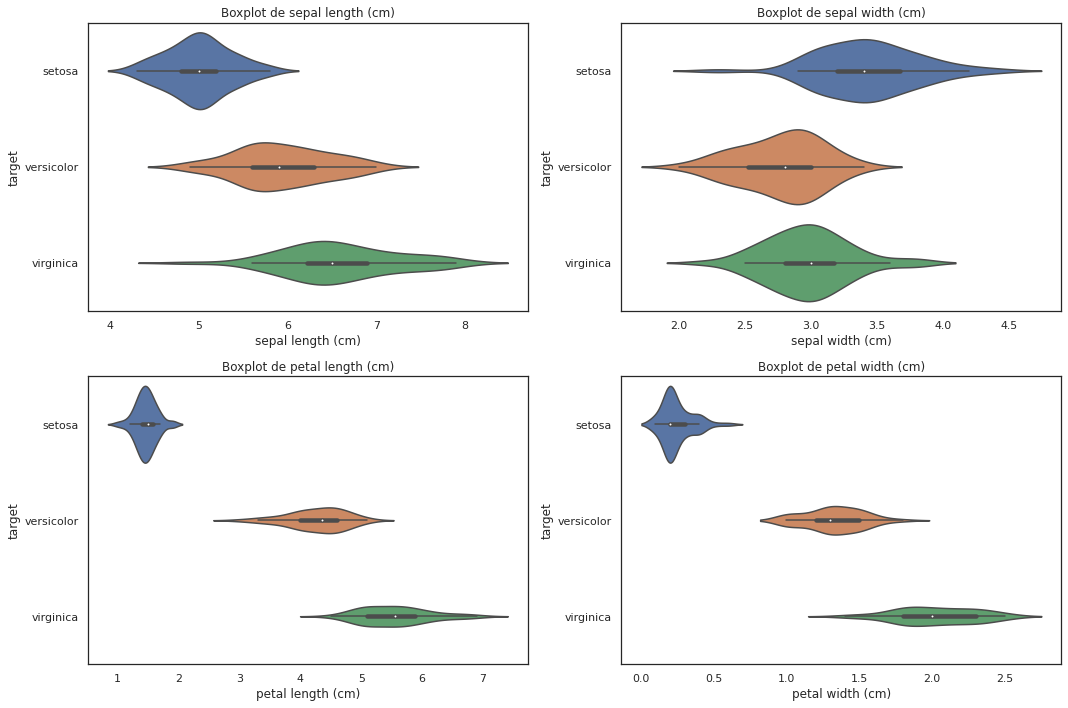

In [5]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10))
medidas = iris_desc.columns
for i in range(0,4):
  j = i + 1
  plt.subplot(2,2,j)
  sns.violinplot(x = medidas[i], y = "target", data = iris_desc, orient = "h")
  plt.title("Boxplot de {}".format(medidas[i]))

plt.tight_layout()

Por fim, podemos checar se os níveis da variável target são balanceados a partir de um gráfico de barras:

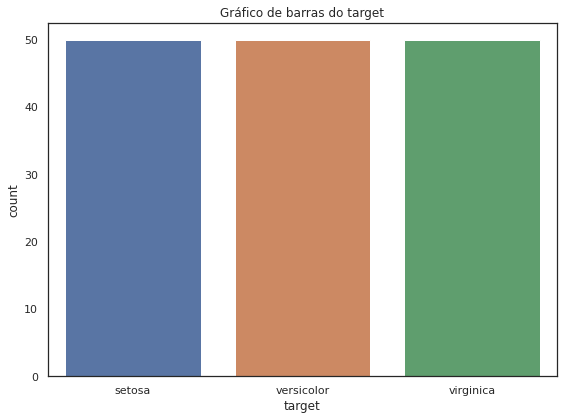

In [6]:
fig, axes = plt.subplots(figsize = (8, 6))
sns.countplot(x = 'target', data = iris_desc)
plt.title("Gráfico de barras do target")
plt.tight_layout()

Parece haver uma igualdade de frequência das diferentes espécies. Assim, vemos pela matriz de correlação alta correlação entre comprimento de sépala e ambas medidas de pétala (comprimento e largura). Além disso, o comprimento de pétala tem alta correlação com a largura. Podemos reduzir a dimensão da matriz de covariaveis ao utilizar uma analise de componentes principais. Isso será interessante para analisar de forma bivariada a performance dos modelos a seguir:

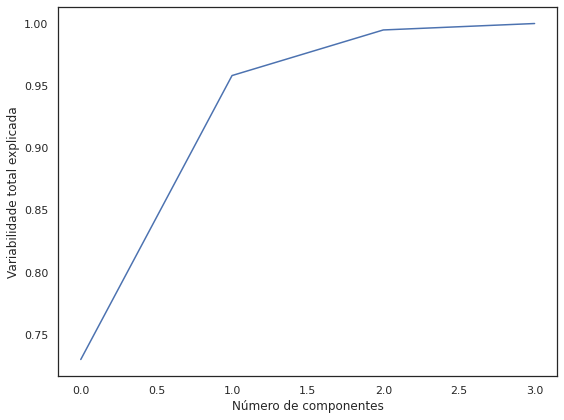

In [7]:
# separando features e target
X = iris_data.iloc[:, 0:4].values
y = iris_data.iloc[:, 4].values

# escalonando os dados
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

# obtendo o PCA com todos os componentes
pca = PCA()
pca_fit = pca.fit(X)
# avaliando a variancia explicada
fig, axes = plt.subplots(figsize = (8, 6))
plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
plt.xlabel("Número de componentes")
plt.ylabel("Variabilidade total explicada")
plt.tight_layout()

Observa-se que dois componentes de fato são suficientes para a analise, tendo portanto:

In [8]:
pca = PCA(n_components=2)

pcs = pca.fit_transform(X)

pcs[1:10, :]
X = pcs

Obtendo um gráfico de dispersão 2D com os dois componentes principais:

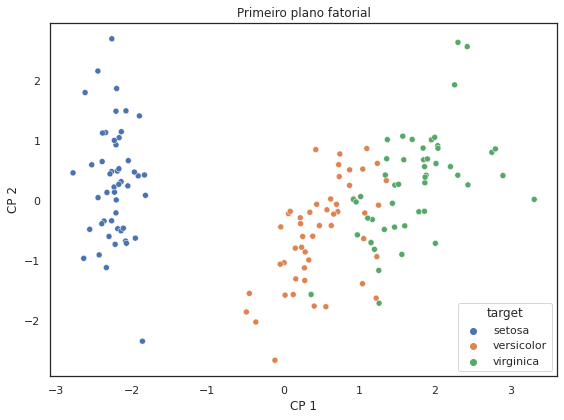

In [9]:
principalDf = pd.DataFrame(data = pcs,
             columns = ['CP 1', 'CP 2'])

principalDf = pd.concat([principalDf, iris_desc[['target']]], axis = 1)

fig, axes = plt.subplots(figsize = (8, 6))
sns.scatterplot(data = principalDf, x = "CP 1", y = "CP 2", hue = "target")
plt.title("Primeiro plano fatorial")
plt.tight_layout()

Podemos então agora, utilizando o pacote modAL para realizar um active learning, utilizando inicialmente a amostragem por incerteza, e posteriormente o queriyng by comitee:

In [10]:
# importando estimadores tanto para amostrar pela incerteza quanto montar o comite
!pip install modAL
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from modAL import ActiveLearner, Committee
from modAL.uncertainty import uncertainty_sampling

# declarando o learner para o random forest
learner_rf = ActiveLearner(
    estimator = RandomForestClassifier(),
    query_strategy = uncertainty_sampling
)

# declarando o learner para o KNN
learner_knn = ActiveLearner(
    estimator = KNeighborsClassifier(n_neighbors = 5),
    query_strategy = uncertainty_sampling
)

# fixando a semente
seed = 1450
np.random.seed(seed)

# setando as amostras iniciais:
# 20 para treinamento inicial
n_initial = 20
X_pool = np.copy(X)
y_pool = np.copy(y)
train_idx = np.random.choice(range(X_pool.shape[0]), size = n_initial, replace = False)
X_train = X_pool[train_idx]
y_train = y_pool[train_idx]

# reduzindo a pool
X_pool = np.delete(X_pool, train_idx, axis=0)
y_pool = np.delete(y_pool, train_idx)

# tomando uma pool para RF e outra para KNN
X_pool_rf = np.copy(X_pool)
y_pool_rf = np.copy(y_pool)

X_pool_knn = np.copy(X_pool)
y_pool_knn = np.copy(y_pool)

learner_rf.teach(X_train, y_train)
learner_knn.teach(X_train, y_train)

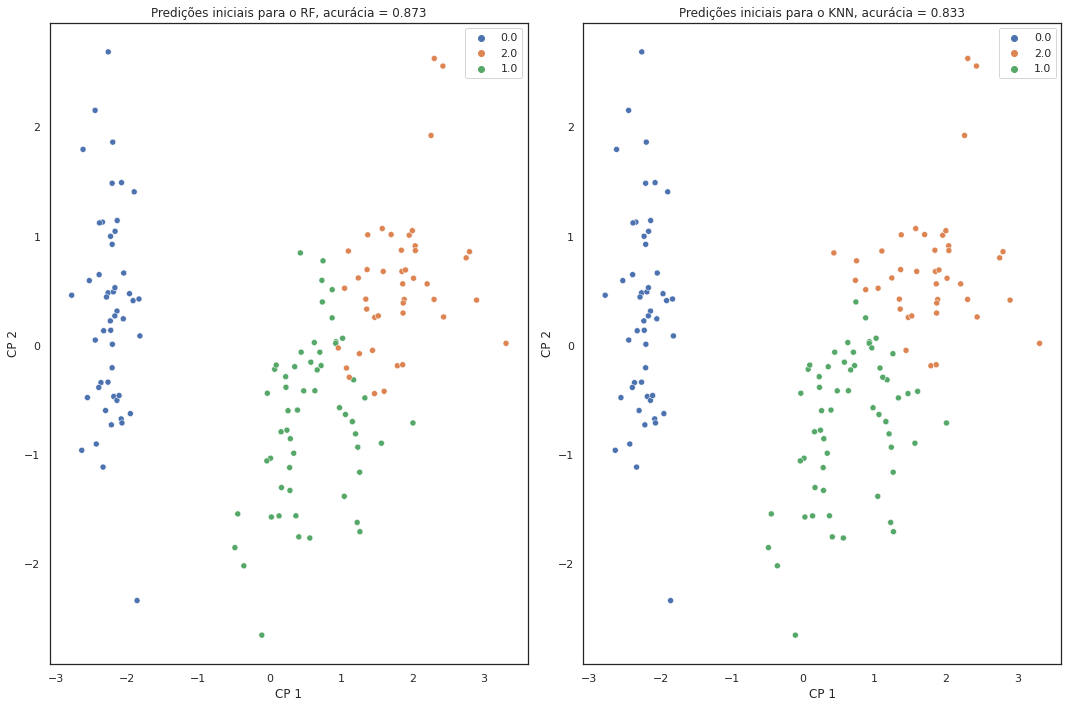

In [11]:
unqueried_score_rf = learner_rf.score(X, y)
unqueried_score_knn = learner_knn.score(X, y)

unqueried_scores = [unqueried_score_rf, unqueried_score_knn]
learners = [learner_rf, learner_knn]
names = ["RF", "KNN"]
plt.figure(figsize = (15, 10))

for i in range(0,2):
  plt.subplot(1, 2, i + 1)
  prediction = learners[i].predict(X)
  sns.scatterplot(data = principalDf, x = "CP 1", y = "CP 2", hue = prediction.astype('str'))
  plt.title("Predições iniciais para o %s, acurácia = %1.3f" % (names[i], unqueried_scores[i]))

plt.tight_layout()

In [12]:
n_queries = 20
performance_history_rf = [unqueried_score_rf]
performance_history_knn = [unqueried_score_knn]


for index in range(n_queries):
  # obtendo o indice para perguntar os labels
  query_index_rf, query_instance_rf = learner_rf.query(X_pool_rf)
  query_index_knn, query_instance_knn = learner_knn.query(X_pool_knn)

  # ensinando o activelearner
  # Random Forest
  X_sel, y_sel = X_pool_rf[query_index_rf].reshape(1, -1), y_pool_rf[query_index_rf].reshape(1, )
  learner_rf.teach(X = X_sel, y = y_sel)
  X_pool_rf, y_pool_rf = np.delete(X_pool_rf, query_index_rf, axis=0), np.delete(y_pool_rf, query_index_rf)
  
  # KNN
  X_sel, y_sel = X_pool_knn[query_index_knn].reshape(1, -1), y_pool_knn[query_index_knn].reshape(1, )
  learner_knn.teach(X = X_sel, y = y_sel)
  X_pool_knn, y_pool_knn = np.delete(X_pool_knn, query_index_knn, axis=0), np.delete(y_pool_knn, query_index_knn)

  # acuracia para cada modelo com a nova observacao
  model_accuracy_rf = learner_rf.score(X, y)
  model_accuracy_knn = learner_knn.score(X, y)
  
  # historico de performance para ambos
  performance_history_rf.append(model_accuracy_rf)
  performance_history_knn.append(model_accuracy_knn)

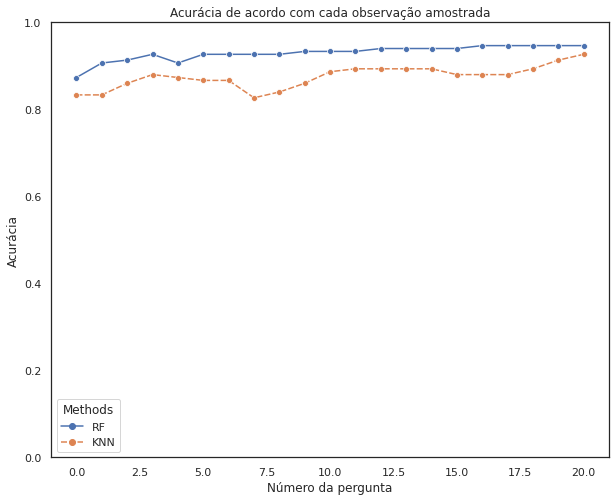

In [13]:
names = ["RF", "KNN"]
plt.figure(figsize = (10, 8))

data = pd.DataFrame(data = {'Acuracia': performance_history_rf + performance_history_knn, 
                            'Query': np.tile(np.arange(0,21), 2),
                            'Methods':np.concatenate((np.full(shape = 21, fill_value = "RF"), 
                                                         np.full(shape = 21, fill_value = "KNN")))})

sns.lineplot(data = data, x = "Query", y = "Acuracia", markers=["o", "o"], hue = "Methods", style="Methods") 
plt.title("Acurácia de acordo com cada observação amostrada")
plt.xlabel("Número da pergunta")
plt.ylabel("Acurácia")
plt.ylim(0, 1)
plt.show()

In [14]:
# iniciando o comite
n_members = 2
learner_list = list()

# tomando a pool inicial
n_initial = 20
X_pool = np.copy(X)
y_pool = np.copy(y)
train_idx = np.random.choice(range(X_pool.shape[0]), size = n_initial, replace = False)
X_train = X_pool[train_idx]
y_train = y_pool[train_idx]
X_pool = np.delete(X_pool, train_idx, axis=0)
y_pool = np.delete(y_pool, train_idx)

# lista de classificadores sendo usado
classifier_list = ["RandomForestClassifier()", "KNeighborsClassifier()"]

for member_idx in range(n_members):

    # iniciando os learner
    learner = ActiveLearner(
        estimator= eval(classifier_list[member_idx]),
        X_training = X_train, y_training = y_train
    )
    learner_list.append(learner)

# assembling the committee
committee = Committee(learner_list=learner_list)

Fazendo o active learner e o histórico de performance do query by comittee:

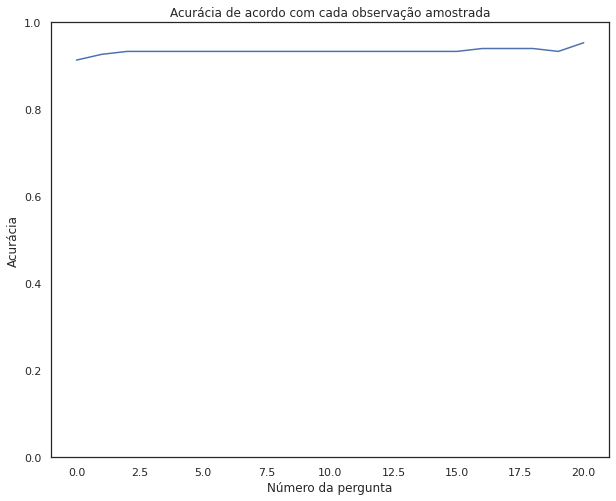

In [15]:
unqueried_score = committee.score(X, y)
performance_history = [unqueried_score]

# query by committee
n_queries = 20
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool)
    committee.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    performance_history.append(committee.score(X, y))
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)

plt.figure(figsize = (10, 8))

data = pd.DataFrame(data = {'Acuracia': performance_history, 
                            'Query': np.arange(0,21)})

sns.lineplot(data = data, x = "Query", y = "Acuracia", markers=True) 
plt.title("Acurácia de acordo com cada observação amostrada")
plt.xlabel("Número da pergunta")
plt.ylabel("Acurácia")
plt.ylim(0, 1)
plt.show()

Agora que treinamos a sintaxe no banco de dados IRIS, façamos um teste em um banco de dados com label binario e com bastante observação. Usaremos o banco de dados de marketing de banco:

In [16]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [17]:
# lendo os dados
bank_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/active_learning/bank.csv', sep = ";")
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [18]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [19]:
bank_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


Primeiramente, podemos analisar os boxplots de cada feature e separar de acordo com o label:

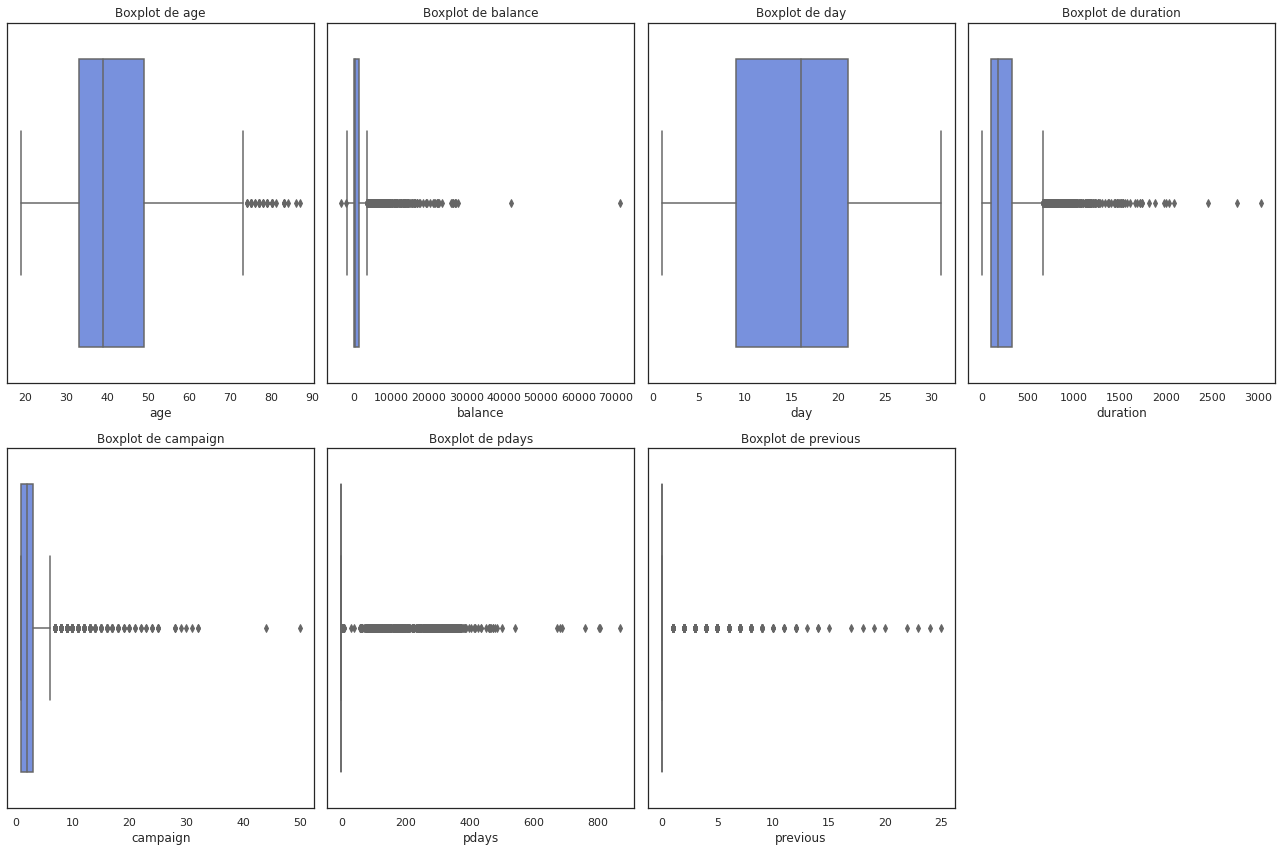

In [20]:
sns.set_palette("coolwarm")
sns.color_palette("Set1")
columns_int = bank_df.select_dtypes(include='number').columns

fig, axes = plt.subplots(2, 4, figsize = (18, 12))

i = 0
for col in columns_int:
  i += 1
  plt.subplot(2, 4, i)
  sns.boxplot(data = bank_df, x = col)
  plt.title("Boxplot de {}".format(col))
  plt.xlabel(col)

fig.delaxes(axes[1][3])
plt.tight_layout()

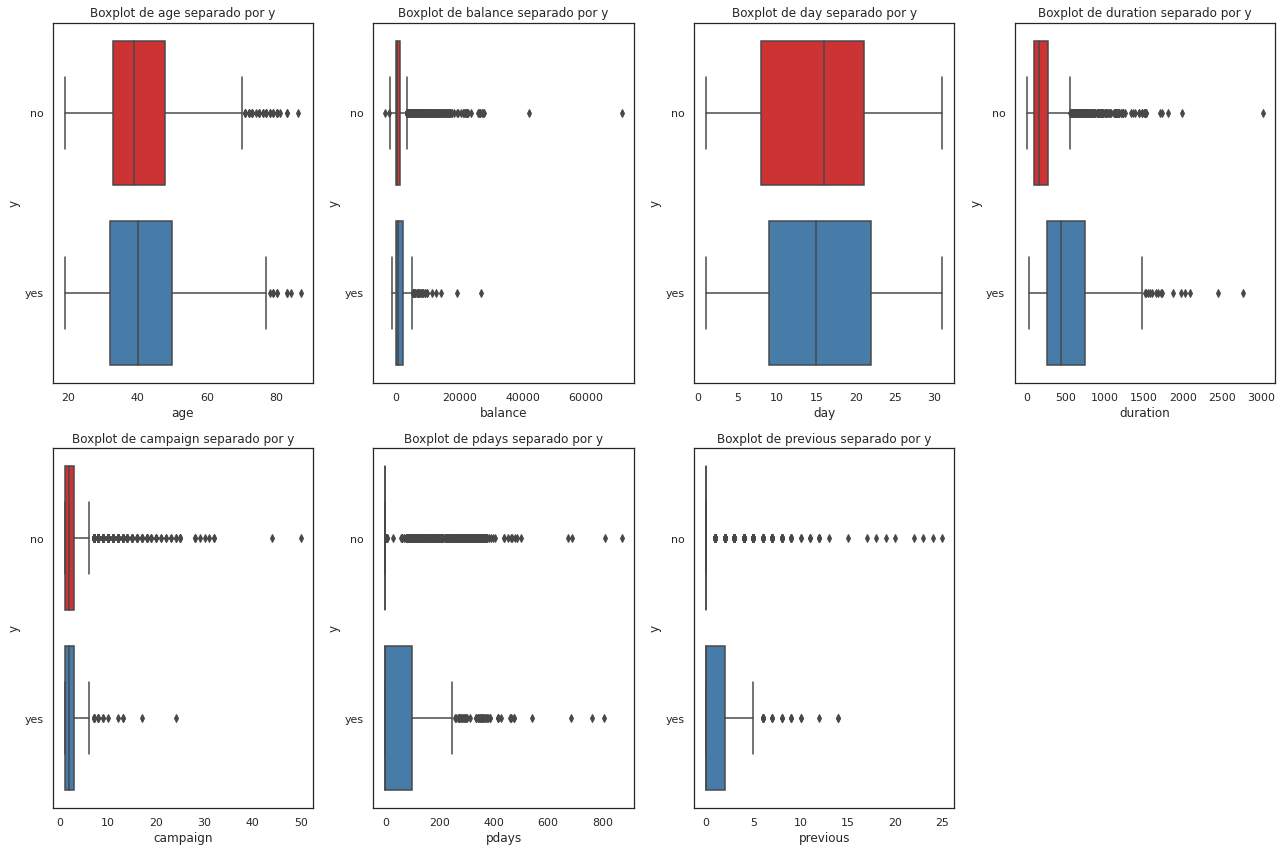

In [21]:
sns.set_palette("Set1") 
columns_int = bank_df.select_dtypes(include='number').columns

fig, axes = plt.subplots(2, 4, figsize = (18, 12))

i = 0
for col in columns_int:
  i += 1
  plt.subplot(2, 4, i)
  sns.boxplot(data = bank_df, x = col, y = "y", orient = "h")
  plt.title("Boxplot de {} separado por y".format(col))
  plt.xlabel(col)

fig.delaxes(axes[1][3])
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1440x360 with 0 Axes>

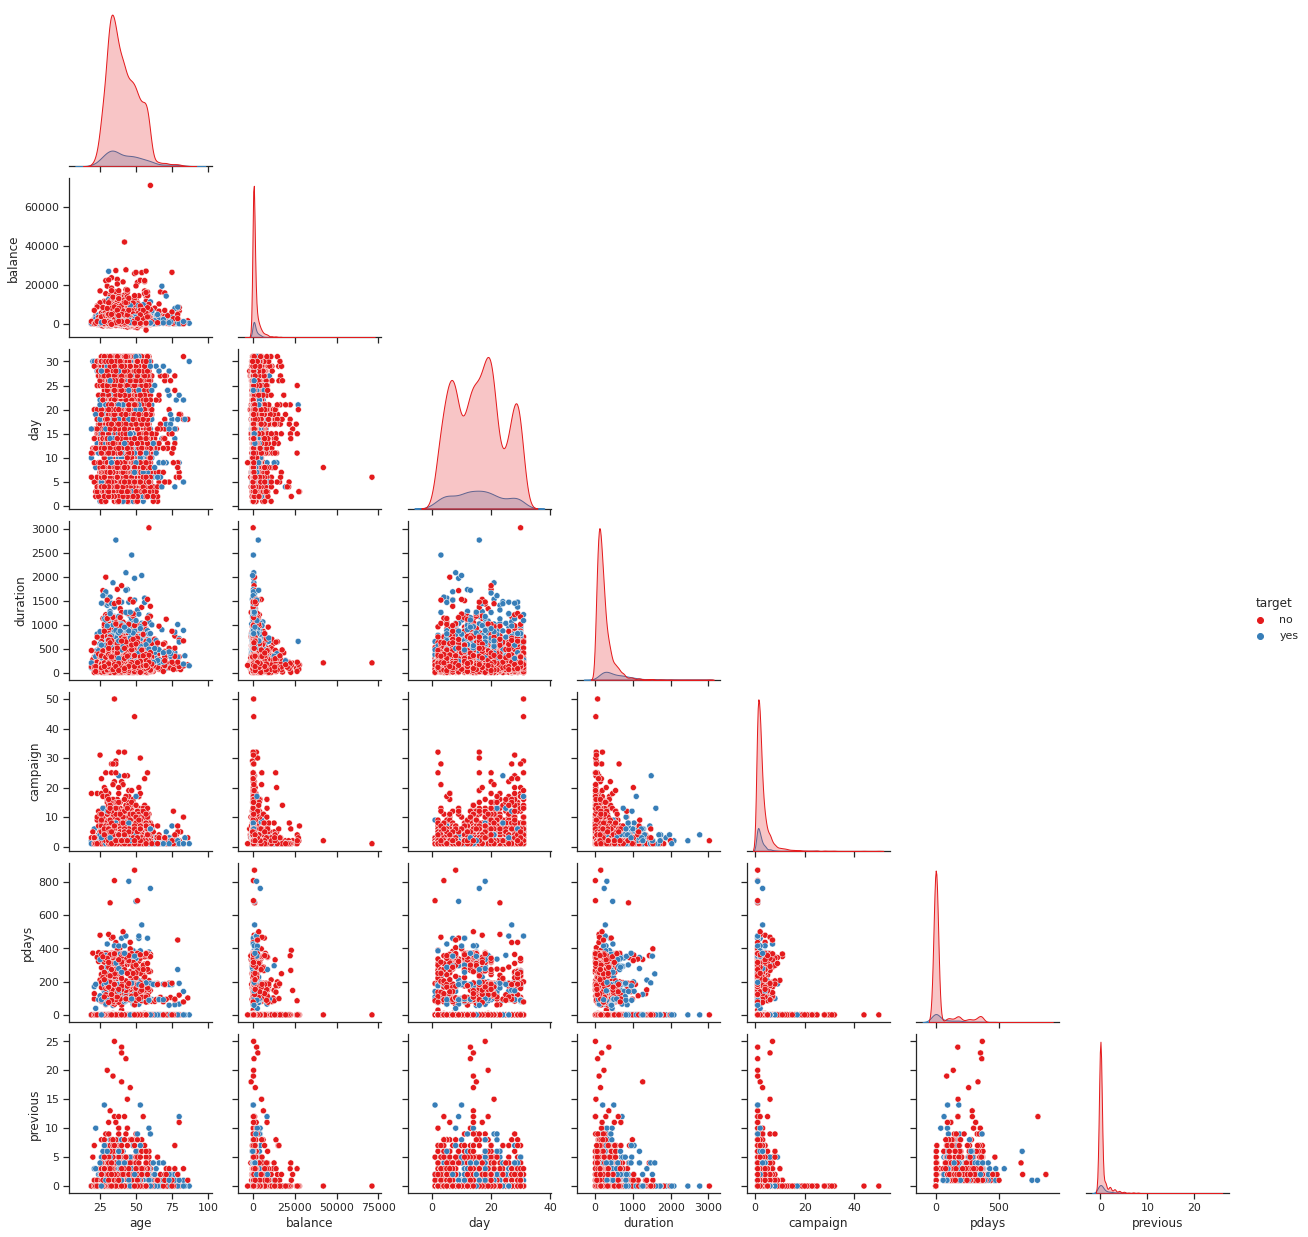

In [22]:
bank_desc = bank_df.select_dtypes(include='number')
sns.set_style("ticks")
bank_desc["target"] = bank_df.loc[:, "y"]

plt.figure(figsize = (20,5))
sns.pairplot(bank_desc, hue = "target", corner=True)
plt.show()

Analisando agora as variáveis categóricas:

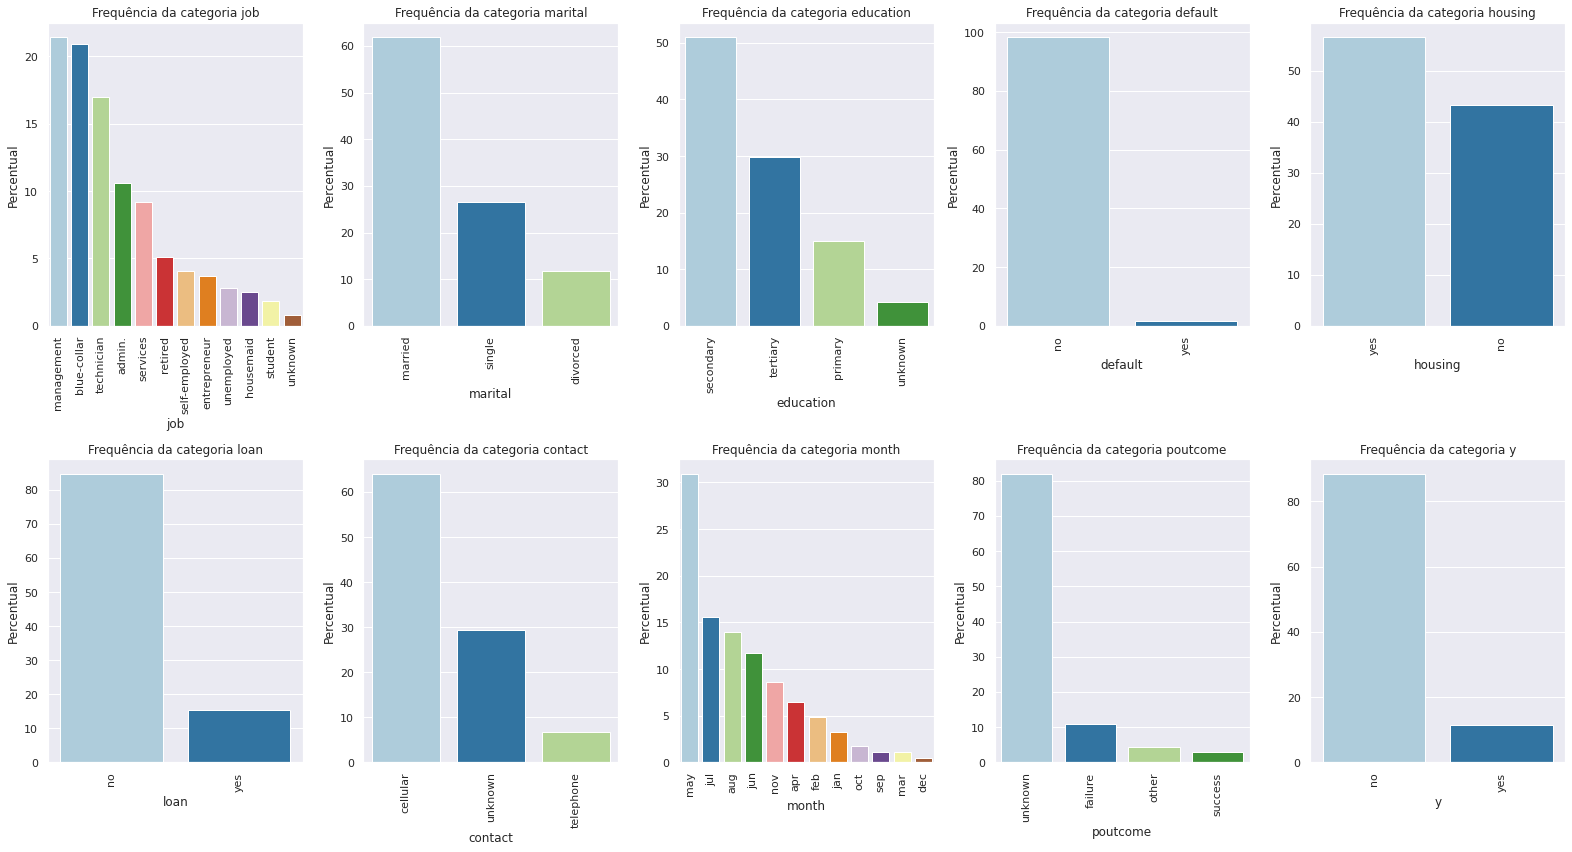

In [23]:
# visualizando a partir de varios gráficos de barras
sns.set_theme(style="darkgrid")
sns.set_palette("Paired")
columns_cat = bank_df.select_dtypes(include='object').columns

fig, axes = plt.subplots(2, 5, figsize = (22, 12))

i = 0
for col in columns_cat:
  i += 1
  plt.subplot(2, 5, i)
  temp_data = (bank_df.loc[:, col].value_counts(normalize = True)
  .mul(100)
  .rename('percent')
  .reset_index())
  sns.barplot(x="index", y="percent", data = temp_data)
  plt.title("Frequência da categoria {}".format(col))
  plt.xlabel(col)
  plt.ylabel("Percentual")
  plt.xticks(rotation=90)

plt.tight_layout()

Separando os dados pelo target, para analisar quao bem cada feature separa bem o target:

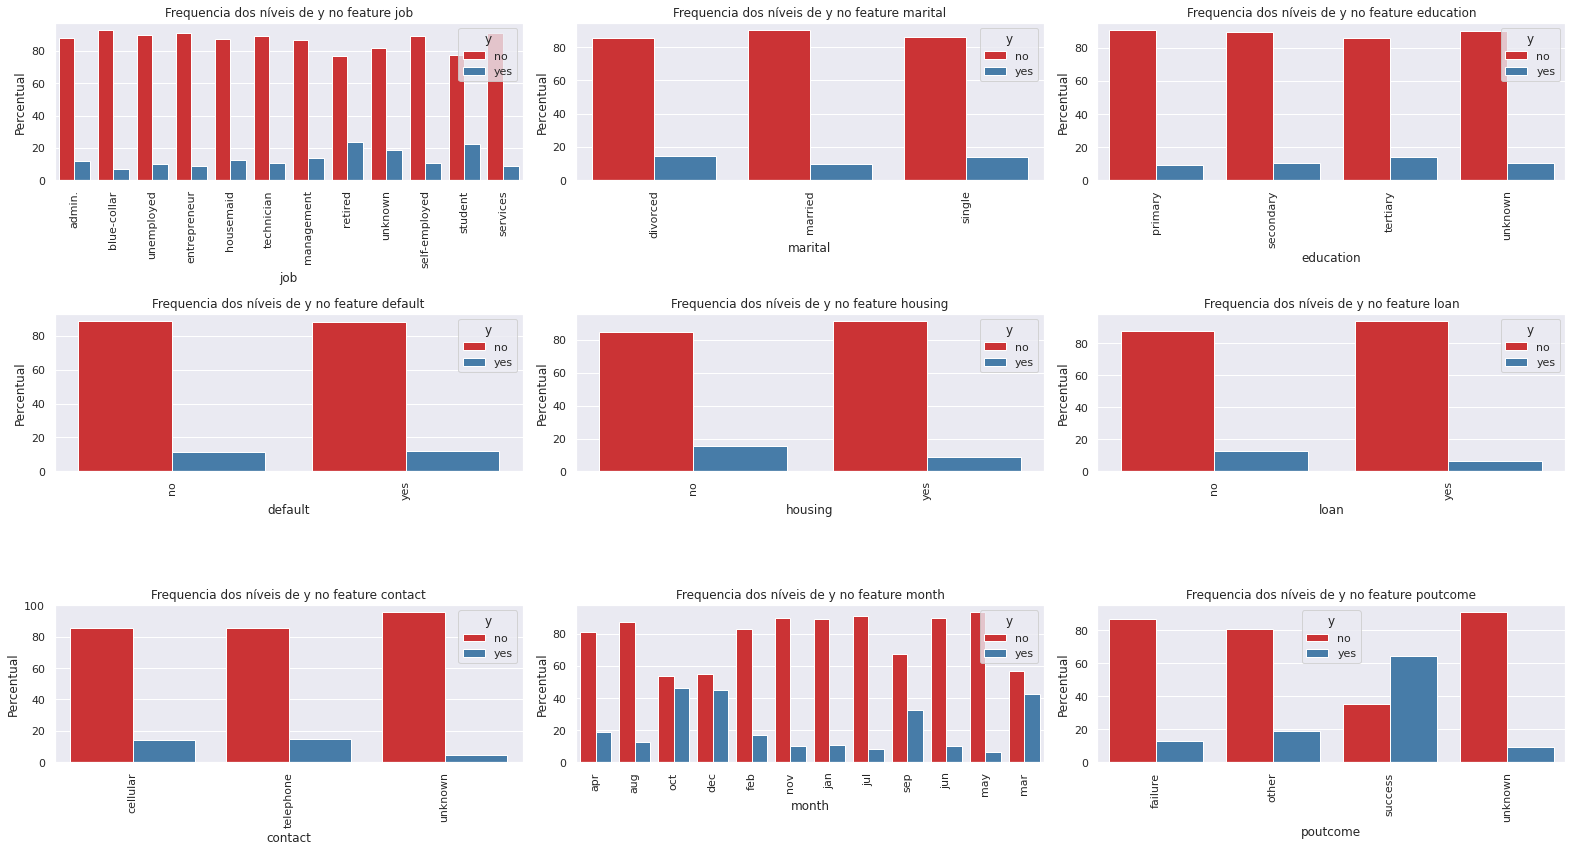

In [24]:
sns.set_palette("Set1")
columns_cat = (bank_df.select_dtypes(include='object')
.drop(["y"], axis = 1).columns)

fig, axes = plt.subplots(3, 3, figsize = (22, 12))

i = 0
for col in columns_cat:
  i += 1
  plt.subplot(3, 3, i)
  temp_data = (bank_df.groupby([col])['y']
               .value_counts(normalize = True)
  .mul(100)
  .rename('percent')
  .reset_index()
  .sort_values('y'))
  sns.barplot(x = col, y="percent", hue = "y", data = temp_data)
  plt.title("Frequencia dos níveis de y no feature {}".format(col))
  plt.xlabel(col)
  plt.ylabel("Percentual")
  plt.xticks(rotation=90)

plt.tight_layout()

Separando agora as covariaveis e os labels para posteriormente dividir em treino e teste:

In [25]:
# transformando categoricas em dummy e escalonando variaveis continuas
# selecionando o nome das colunas continuas e categoricas
cols_ind = (bank_df.select_dtypes(include='object').drop(['y'], axis = 1)
.columns)

cols_num = (bank_df.select_dtypes(include = "number")).columns


# usando column transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(drop = "first", sparse = False)

preprocessor = ColumnTransformer(transformers = [('num', numeric_transformer, cols_num),
                                                 ('cat', categorical_transformer, cols_ind)])

# Separando X e y
y = bank_df.loc[:, 'y'].map(dict(yes=1, no=0)).values
# trocando y por 0 e 1
X = preprocessor.fit_transform(bank_df.drop(['y'], axis = 1))


# separando em pool e teste
from sklearn.model_selection import train_test_split
X_train_total, X_test, y_train_total, y_test = train_test_split(X, y, test_size = 0.3, random_state = 120, stratify = y)

Agora que separamos a pool e o teste, podemos por fim, selecionar 30 observações para compor nosso conjunto inicial

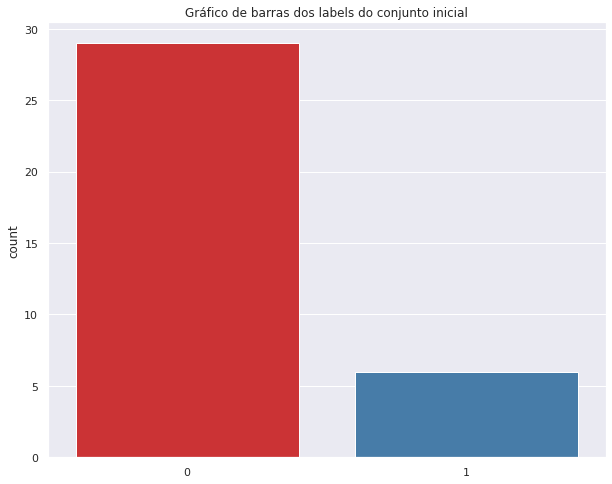

In [26]:
seed = 120
np.random.seed(seed)
n_initial = 35

train_idx = np.random.choice(range(len(X_pool)), size = n_initial, replace = False)
X_train = X_train_total[train_idx]
y_train = y_train_total[train_idx]

X_pool = np.delete(X_train_total, train_idx, axis=0)
y_pool = np.delete(y_train_total, train_idx)

plt.figure(figsize = (10,8))
sns.countplot(x = y_train)
plt.title("Gráfico de barras dos labels do conjunto inicial")
plt.show()

Formando o comitê e classificadores separados pelo qual usaremos medida de incerteza.

In [27]:
# lista de classificadores que serão usados
# importando outros classificadores
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from modAL.models import Committee, ActiveLearner
from modAL.disagreement import vote_entropy_sampling
from modAL.uncertainty import uncertainty_sampling

# criando dois comitês de modelos semelhantes
# modelos nao parametricos 
commitee_1_list = [RandomForestClassifier(n_estimators = 150, max_depth = 5),
                 BaggingClassifier(n_estimators = 100),
                 KNeighborsClassifier(n_neighbors = 5), 
                 AdaBoostClassifier()]
n_members_1 = len(commitee_1_list)

# funcao para iniciar o comite e uma lista de learners
def initialize_comitee(classifier_list, X_train, y_train, sel_strategy = vote_entropy_sampling):
  n_members = len(classifier_list)
  learner_list = list()

  for member_idx in range(n_members):
    # iniciando os learner
    learner = ActiveLearner(
        estimator= classifier_list[member_idx],
        X_training = X_train, y_training = y_train
    )
    learner_list.append(learner)

  # assembling the committee
  committee = Committee(learner_list=learner_list,
                        query_strategy = sel_strategy)
  return committee, learner_list


bank_committee, learner_list = initialize_comitee(commitee_1_list, X_train, y_train)
bank_committee.predict_proba(X_test)

array([[0.97013511, 0.02986489],
       [0.91418329, 0.08581671],
       [0.52411894, 0.47588106],
       ...,
       [0.96139405, 0.03860595],
       [0.85370536, 0.14629464],
       [0.7504973 , 0.2495027 ]])

Podemos rapidamente analisar a curva ROC do comitê apenas com o conjunto de treinamento inicial:

AUC: 0.754


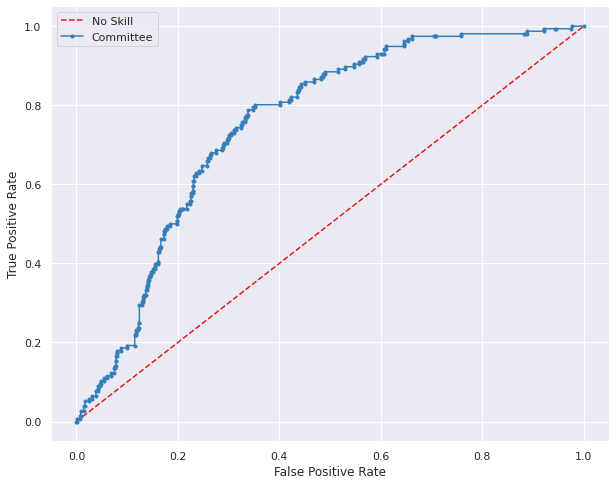

0.11108662256855228

In [28]:
# para obter recall, precision, AUC e a propria curva ROC
from sklearn import metrics
com_fpr, com_tpr, thresholds = metrics.roc_curve(y_test, bank_committee.predict_proba(X_test)[:, 1])

com_auc = metrics.roc_auc_score(y_test, bank_committee.predict_proba(X_test)[:, 1])
print('AUC: %.3f' % com_auc)
plt.figure(figsize = (10, 8))

# sem habilidade para comparacao
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(com_fpr, com_tpr, marker='.', label='Committee')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
optimal_idx = np.argmax(com_tpr - com_fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

Primeiramente, obteremos a performance pelo comite através de recall e precision e testaremos a partir de um dado número de consultas:

In [31]:
# definindo funcao para o procedimento de active learning no comite
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

def active_learning_comitee(n_query, committee, X_pool, y_pool, X_test, y_test, probs_list = None):
  # pegando o melhor limite inicial
  fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                  bank_committee.predict_proba(X_test)[:, 1])
  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]

  # predizendo a partir disso
  y_pred = (committee.predict_proba(X_test)[:, 1] > 
            optimal_threshold).astype(int)

  # calculando F1 e AUC
  F1_history = [metrics.f1_score(y_test, y_pred)]
  AUC_history = [metrics.roc_auc_score(y_test,
                                committee.predict_proba(X_test)[:, 1])]

  # copiando as duas pools e o comite para nao haver problema de modificacao do 
  # comite e pool original
  X_pool_loc = np.copy(X_pool)
  y_pool_loc = np.copy(y_pool)
  committee_loc = clone(committee)

  # probabilidades selecionadas
  probs_select = []
  for idx in range(n_query):
   # query by committee
    query_idx, query_instance = committee_loc.query(X_pool_loc)
    committee_loc.teach(
        X = X_pool_loc[query_idx].reshape(1, -1),
        y = y_pool_loc[query_idx].reshape(1, )
    )

    # calculando curva ROC e threshold
    # se estiver na lista de probabilidades, adicionar as probs
    try:
      if (idx + 1) in probs_list:
        probs_select.append(committee_loc.predict_proba(X_test)[:, 1])
    except:
      print("a")
      probs_list = []
    fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                    committee_loc.predict_proba(X_test)[:, 1])
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

  # predizendo a partir disso
    y_pred = (committee_loc.predict_proba(X_test)[:, 1] > 
              optimal_threshold).astype(int)
    probs = committee_loc.predict_proba(X_test)[:,1]

    F1_history.append(metrics.f1_score(y_test, y_pred))
    AUC_history.append(metrics.roc_auc_score(y_test, 
                                    probs))

    # remove queried instance from pool
    X_pool_loc = np.delete(X_pool_loc, query_idx, axis=0)
    y_pool_loc = np.delete(y_pool_loc, query_idx)

  return AUC_history, F1_history, committee_loc, probs_select

def random_learning(n_query, n_trials, models, X_pool, y_pool, X_test, y_test, random_state = 1250):
  np.random.seed(random_state)
  if isinstance(models, dict):
    F1_random, AUC_random = dict(), dict()
    for keys in models:
      # pegando o melhor limite inicial
      fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                  models[keys].predict_proba(X_test)[:, 1])
      optimal_idx = np.argmax(tpr - fpr)
      optimal_threshold = thresholds[optimal_idx]

      # predizendo a partir disso
      y_pred = (models[keys].predict_proba(X_test)[:, 1] > 
            optimal_threshold).astype(int)

      # calculando F1 e AUC
      F1_random[keys] = [metrics.f1_score(y_test, y_pred)]
      AUC_random[keys] = [metrics.roc_auc_score(y_test,
                                models[keys].predict_proba(X_test)[:, 1])]                     

      # antes de começar as diversas tentativas, criamos um array para soma
      sum_F1, sum_AUC = np.zeros(n_query), np.zeros(n_query)
      for i in range(0, n_trials):
        # copiando as pools
        X_pool_rand, y_pool_rand = np.copy(X_pool), np.copy(y_pool)

        # clonando o modelo inicial
        model_rand  = clone(models[keys])
        F1_temp = []
        AUC_temp = [] 
        for idx in range(n_query):  
          # consulta por amostragem aleatoria
          sample_idx = np.random.choice(range(len(X_pool_rand)), size = 1, replace = False)
          model_rand.teach(
              X = X_pool_rand[sample_idx].reshape(1, -1),
                y = y_pool_rand[sample_idx].reshape(1, )
                  )
          
          # calculando curva ROC e threshold
          fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                    model_rand.predict_proba(X_test)[:, 1])
          optimal_idx = np.argmax(tpr - fpr)
          optimal_threshold = thresholds[optimal_idx]

          # predizendo a partir disso
          y_pred = (model_rand.predict_proba(X_test)[:, 1] > 
              optimal_threshold).astype(int)
          probs = model_rand.predict_proba(X_test)[:,1]

          F1_temp.append(metrics.f1_score(y_test, y_pred))
          AUC_temp.append(metrics.roc_auc_score(y_test, 
                                    probs))

          # removendo da pool
          X_pool_rand = np.delete(X_pool_rand, query_idx, axis=0)
          y_pool_rand = np.delete(y_pool_rand, query_idx)
        sum_F1 += np.array(F1_temp)
        sum_AUC += np.array(AUC_temp)
      F1_random[keys] += list(sum_F1/n_trials)
      AUC_random[keys] += list(sum_AUC/n_trials)
  else:
    # pegando o melhor limite inicial
    fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                  models.predict_proba(X_test)[:, 1])
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # predizendo a partir disso
    y_pred = (models.predict_proba(X_test)[:, 1] > 
            optimal_threshold).astype(int)

    # calculando F1 e AUC
    F1_random = [metrics.f1_score(y_test, y_pred)]
    AUC_random = [metrics.roc_auc_score(y_test,
                                models.predict_proba(X_test)[:, 1])]                     

    # antes de começar as diversas tentativas, criamos um array para soma
    sum_F1, sum_AUC = np.zeros(n_query), np.zeros(n_query)
    for i in range(0, n_trials):
      # copiando as pools
      X_pool_rand, y_pool_rand = np.copy(X_pool), np.copy(y_pool)

      # clonando o modelo inicial
      model_rand  = clone(models)
      F1_temp = []
      AUC_temp = [] 
      for idx in range(n_query):  
        # consulta por amostragem aleatoria
        sample_idx = np.random.choice(range(len(X_pool_rand)), size = 1, replace = False)
        model_rand.teach(
              X = X_pool_rand[sample_idx].reshape(1, -1),
                y = y_pool_rand[sample_idx].reshape(1, )
                  )
          
        # calculando curva ROC e threshold
        fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                    model_rand.predict_proba(X_test)[:, 1])
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]

        # predizendo a partir disso
        y_pred = (model_rand.predict_proba(X_test)[:, 1] > 
              optimal_threshold).astype(int)
        probs = model_rand.predict_proba(X_test)[:,1]

        F1_temp.append(metrics.f1_score(y_test, y_pred))
        AUC_temp.append(metrics.roc_auc_score(y_test, 
                                    probs))

        # removendo da pool
        X_pool_rand = np.delete(X_pool_rand, query_idx, axis=0)
        y_pool_rand = np.delete(y_pool_rand, query_idx)
      sum_F1 += np.array(F1_temp)
      sum_AUC += np.array(AUC_temp)
    F1_random += list(sum_F1/n_trials)
    AUC_random += list(sum_AUC/n_trials)
  return F1_random, AUC_random

In [34]:
# usando a funcao e vendo o comportamento num numero grande de query
probs_names = [150, 350, 650, 850, 1050]
AUC_history,  F1_history, committee_new, probs = active_learning_comitee(1250, 
                                                                bank_committee, X_pool, y_pool, X_test, y_test, probs_list = probs_names)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/pytho

In [35]:
# usando o random learning para comparar com caso anterior
F1_random, AUC_random = random_learning(1250, 10, bank_committee, X_pool, y_pool, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/pytho

Plotando a evolução de cada score de interesse de acordo com o numero de consultas:

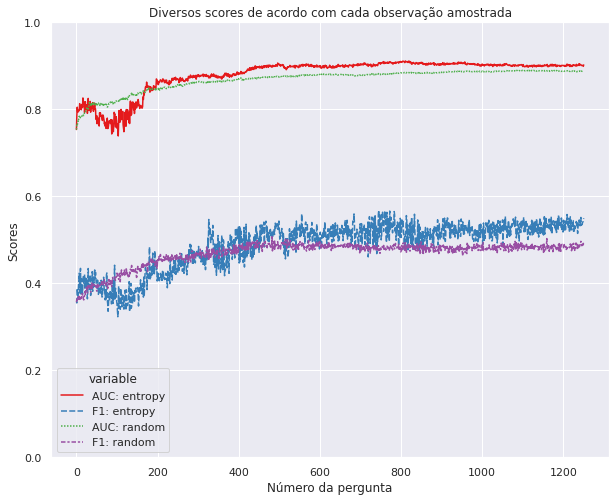

In [36]:
plt.figure(figsize = (10, 8))

temp_data = pd.DataFrame(data = {
                            'AUC: entropy' : AUC_history,
                            'F1: entropy': F1_history,
                            'AUC: random' : AUC_random,
                            'F1: random': F1_random,
                            'Query': np.arange(0,1251)})


# mudando o formato do banco de dados:
melt_data = pd.melt(temp_data, id_vars = ['Query'], value_vars = ['AUC: entropy', 'F1: entropy', 'AUC: random', 'F1: random'])


sns.lineplot(data = melt_data, x = "Query", y = "value", hue = "variable", style="variable") 
plt.title("Diversos scores de acordo com cada observação amostrada")
plt.xlabel("Número da pergunta")
plt.ylabel("Scores")
plt.ylim(0, 1)
plt.show()

Indo por partes, podemos checar se em um modelo considerando o conjunto de treinamento inteiro, como se desempenham os modelos em termos de F1 e ROC

In [ ]:
# lista de modelos

models_list = [RandomForestClassifier(n_estimators = 150, max_depth = 5),
                 BaggingClassifier(n_estimators = 100),
                 KNeighborsClassifier(n_neighbors = 5), 
                 AdaBoostClassifier(),
               LogisticRegression(),
               LogisticRegression(penalty = 'l1', solver = 'liblinear'),
               GaussianNB(),
               GradientBoostingClassifier(random_state = 0),
               committee_new]

names = ["RF", "Bagging", "KNN", "Adaboost", "Ridge", "Lasso", "NBGauss", "Gradient Boosting", "comite"]
i = 0
fpr_dict = dict()
tpr_dict = dict()

all_F1 = list()
all_AUC = list()

for model in models_list:
  if model != committee_new:
    model.fit(X_train_total, y_train_total)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                    model.predict_proba(X_test)[:, 1])
  else:
    fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                    model.predict_proba(X_test)[:, 1])
  fpr_dict[names[i]] = fpr
  tpr_dict[names[i]] = tpr
  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]
  # predizendo e pegando os valores de AUC e F1
  y_pred = (model.predict_proba(X_test)[:, 1] > 
              optimal_threshold).astype(int)
  probs = model.predict_proba(X_test)[:,1]
  all_F1.append(metrics.f1_score(y_test, y_pred))
  all_AUC.append(metrics.roc_auc_score(y_test, 
                                    probs))
  i += 1
  

measures = pd.DataFrame(data = {'F1' : all_F1,
                     'AUC' : all_AUC}, index = names)
measures


,F1,AUC
RF,0.523139,0.902047
Bagging,0.549801,0.912669
KNN,0.451411,0.802726
Adaboost,0.525896,0.902229
Ridge,0.492091,0.899128
Lasso,0.496377,0.900275
NBGauss,0.417745,0.818821
Gradient Boosting,0.535104,0.918513
comite,0.449324,0.871902


Plotando as curvas ROC juntas

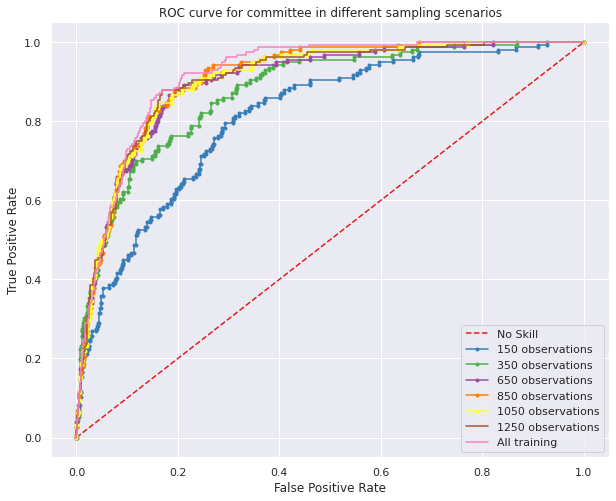

In [37]:
bank_committee_inteiro , _ = initialize_comitee(commitee_1_list, X_train_total, 
                                                y_train_total)

all_fpr, all_tpr, thresholds = metrics.roc_curve(y_test, 
                                    bank_committee_inteiro.predict_proba(X_test)[:, 1])


plt.figure(figsize = (10, 8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# sem habilidade para comparacao
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)


for i in range(len(probs_names)):
  fpr, tpr, _ = metrics.roc_curve(y_test, probs[i])
  # plotando a curva ROC
  plt.plot(fpr, tpr, marker='.', label="{} observations".format(probs_names[i]))

unc_fpr, unc_tpr, _ = metrics.roc_curve(y_test, 
                                    committee_new.predict_proba(X_test)[:, 1])

plt.plot(unc_fpr, unc_tpr, label = "1250 observations")
plt.plot(all_fpr, all_tpr, label = "All training")
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve for committee in different sampling scenarios")
# show the legend
plt.legend()
# show the plot
plt.show()

Comparemos agora o random sampling com o uncertainty sampling e vejamos como se desenvolve o resultado se expandirmos muito a amostra:

In [34]:

models_list = [RandomForestClassifier(),
                 BaggingClassifier(n_estimators = 100),
                 KNeighborsClassifier(n_neighbors = 5), 
                 AdaBoostClassifier(),
               LogisticRegression(),
               LogisticRegression(penalty = 'l1', solver = 'liblinear'),
               SVC(kernel = 'linear', gamma = 'auto', probability = True),
               GradientBoostingClassifier(random_state = 0)]

def initialize_learners(models, X_train, y_train, names = None, sel_strategy = uncertainty_sampling):
  n_members = len(models)
  if names == None:
    learner_list = list()
    for member_idx in range(n_members):
    # iniciando os learner
      learner = ActiveLearner(
        estimator= models[member_idx],
        query_strategy = sel_strategy,
        X_training = X_train, y_training = y_train
      )
      learner_list.append(learner)
  else:
    learner_list = dict()
    i = 0
    for member_idx in range(n_members):
    # iniciando os learner
      learner = ActiveLearner(
        estimator= models[member_idx],
        query_strategy = sel_strategy,
        X_training = X_train, y_training = y_train
      )
      learner_list[names[i]] = learner
      i += 1
  return learner_list


names = ["RF", "Bagging", "KNN", "Adaboost", "Ridge", "Lasso", "SVC", "Gradient Boosting"]
learners = initialize_learners(models_list, X_train, y_train, names)

def active_learning_uncertainty(n_query, models, X_pool, y_pool, X_test, y_test, random_state = 1250, **kwargs):
  np.random.seed(random_state)
  # historico de F1 e AUC para a amostragem por incerteza e aleatoria
  F1_all_history, AUC_all_history, final_models  = dict(), dict(), dict()
  for keys in models:
    # pegando o melhor limite inicial
    fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                  models[keys].predict_proba(X_test)[:, 1])
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # predizendo a partir disso
    y_pred = (models[keys].predict_proba(X_test)[:, 1] > 
            optimal_threshold).astype(int)

    # calculando F1 e AUC
    F1_all_history[keys] = [metrics.f1_score(y_test, y_pred)]
    AUC_all_history[keys]= [metrics.roc_auc_score(y_test,
                                models[keys].predict_proba(X_test)[:, 1])]
                             
    # copiando as duas pools para nao haver problema de reproducibilidade
    X_pool_loc,  y_pool_loc = np.copy(X_pool), np.copy(y_pool)

    # dois modelos clonados (um aleatorio e outro para a amostragem por incerteza)
    model_loc  = clone(models[keys])
    for idx in range(n_query):
      # consulta por amostragem por incerteza
      query_idx, query_instance = model_loc.query(X_pool_loc, **kwargs)
      model_loc.teach(
        X = X_pool_loc[query_idx].reshape(1, -1),
        y = y_pool_loc[query_idx].reshape(1, )
    )
    
      # calculando curva ROC e threshold
      fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                    model_loc.predict_proba(X_test)[:, 1])
      optimal_idx = np.argmax(tpr - fpr)
      optimal_threshold = thresholds[optimal_idx]

      # predizendo a partir disso
      y_pred = (model_loc.predict_proba(X_test)[:, 1] > 
              optimal_threshold).astype(int)
      probs = model_loc.predict_proba(X_test)[:,1]

      F1_all_history[keys].append(metrics.f1_score(y_test, y_pred))
      AUC_all_history[keys].append(metrics.roc_auc_score(y_test, 
                                    probs))

      # tirando instancia da pool
      X_pool_loc = np.delete(X_pool_loc, query_idx, axis=0)
      y_pool_loc = np.delete(y_pool_loc, query_idx)
    
    final_models[keys] = model_loc

  return F1_all_history, AUC_all_history, final_models

n_query = 1250

In [31]:

F1_all_history, AUC_all_history, final_models = active_learning_uncertainty(n_query, 
                                                                              learners, X_pool, y_pool, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/pytho

In [35]:
# usando o random learning para comparar com caso anterior
F1_random, AUC_random = random_learning(n_query, 10, learners, X_pool, y_pool, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/pytho

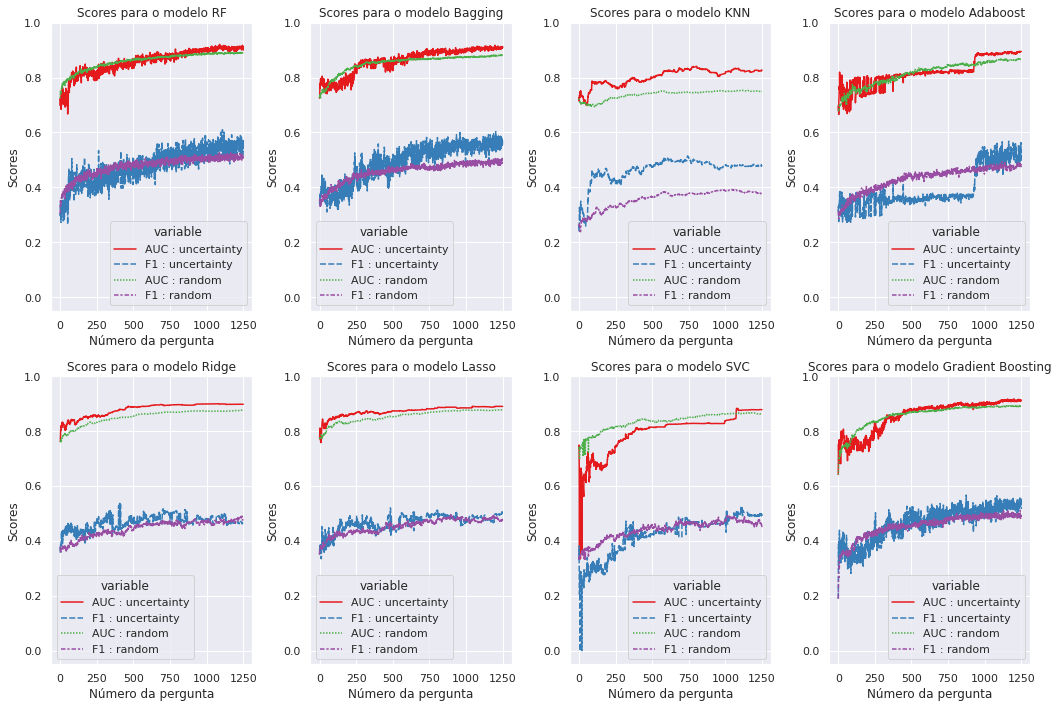

In [54]:
fig, axes = plt.subplots(2, 4, figsize = (15, 10))
tam = len(models_list)


for i in range(0,tam):
  j = i + 1
  plt.subplot(2,4,j)
  temp_data = pd.DataFrame(data = {
                            'AUC : uncertainty' : AUC_all_history[names[i]],
                            'F1 : uncertainty': F1_all_history[names[i]],
                            'AUC : random' : AUC_random[names[i]],
                            'F1 : random' : F1_random[names[i]],
                            'Query': np.arange(0,n_query + 1)})
  melt_data = pd.melt(temp_data, id_vars = ['Query'], 
                  value_vars = ['AUC : uncertainty', 'F1 : uncertainty', 
                                'AUC : random', 'F1 : random'])
  sns.lineplot(data = melt_data, x = "Query", y = "value", hue = "variable", style="variable") 
  plt.title("Scores para o modelo {}".format(names[i]))
  plt.xlabel("Número da pergunta")
  plt.ylabel("Scores")
  plt.ylim(-0.05, 1)

plt.tight_layout()
plt.show()

Testamos as duas estratégias mais clássicas nos dois casos acima. Mas existem ainda duas estratégias com amplo uso principalmente em classificação: Densidade de informação e redução de erro estimado:




*   **Densidade de informação:**






In [41]:
# testando primeiramente para densidade de informacao
# criando uma estratégia própria e testando
from modAL.density import information_density
from modAL.uncertainty import classifier_uncertainty, classifier_margin
from modAL.utils.selection import multi_argmax
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# criando nossa estrategia customizada usando a densidade:
def density_custom_query_strategy(classifier, X, n_instances = 1, base_strategy = classifier_uncertainty, sim_type = "euclidean", beta = 1):
  density = information_density(X, sim_type)
  base_strategy_values = base_strategy(classifier, X)
  utility = np.multiply(base_strategy_values, density**beta)
  query_idx = multi_argmax(utility, n_instances = n_instances)
  return query_idx, X[query_idx]

custom_query_learner_test = ActiveLearner(
    estimator = GaussianProcessClassifier(1.0 * RBF(1.0)),
    query_strategy = density_custom_query_strategy,
    X_training = X_train, y_training=y_train,
)

# fazendo função para esse learner
n_queries = 20
def test_function(n_queries, X_pool, y_pool, learner, **kwargs):
  X_pool_test, y_pool_test = np.copy(X_pool), np.copy(y_pool)
  for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool_test, **kwargs)
    learner.teach(
        X = X_pool_test[query_idx].reshape(1, -1),
        y = y_pool_test[query_idx].reshape(1, )
    )
    X_pool_test = np.delete(X_pool_test, query_idx, axis=0)
    y_pool_test = np.delete(y_pool_test, query_idx)
  return learner


Assim usando essa estratégia especifica, podemos repetir o procedimento anterior, reaproveitando o historico dos scores F1 e AUC obtidos pela amostragem aleatória:

In [42]:
# iniciando de novo os learners, dessa vez usando a estrategia:
models_list = [RandomForestClassifier(),
                 BaggingClassifier(n_estimators = 100),
                 KNeighborsClassifier(n_neighbors = 5), 
                 AdaBoostClassifier(),
               LogisticRegression(),
               LogisticRegression(penalty = 'l1', solver = 'liblinear'),
               SVC(kernel = 'linear', gamma = 'auto', probability = True),
               GradientBoostingClassifier(random_state = 0)]

names = ["RF", "Bagging", "KNN", "Adaboost", "Ridge", "Lasso", "SVC", "Gradient Boosting"]
learners_dens_info = initialize_learners(models_list, X_train, y_train, names, sel_strategy = density_custom_query_strategy)

In [43]:
# rodando a funcao com o learner especifico
# usando os parametros default da estrategia de consulta personalizada
n_query = 1250
# beta = 1
F1_dens_info_beta1, AUC_dens_info_beta1, final_models_beta1 = active_learning_uncertainty(n_query, learners_dens_info, X_pool, y_pool, X_test, y_test, 
                            random_state = 1250)

# beta = 1.25
F1_dens_info_beta1_25, AUC_dens_info_beta1_25, final_models_beta1_25 = active_learning_uncertainty(n_query, learners_dens_info, X_pool, y_pool, X_test, y_test, 
                            random_state = 1250, beta = 1.25)

# beta = 0.85
F1_dens_info_beta0_85, AUC_dens_info_beta0_85, final_models_beta0_85 = active_learning_uncertainty(n_query, learners_dens_info, X_pool, y_pool, X_test, y_test, 
                            random_state = 1250, beta = 0.85)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/pytho

Tomando $\beta = 1$:

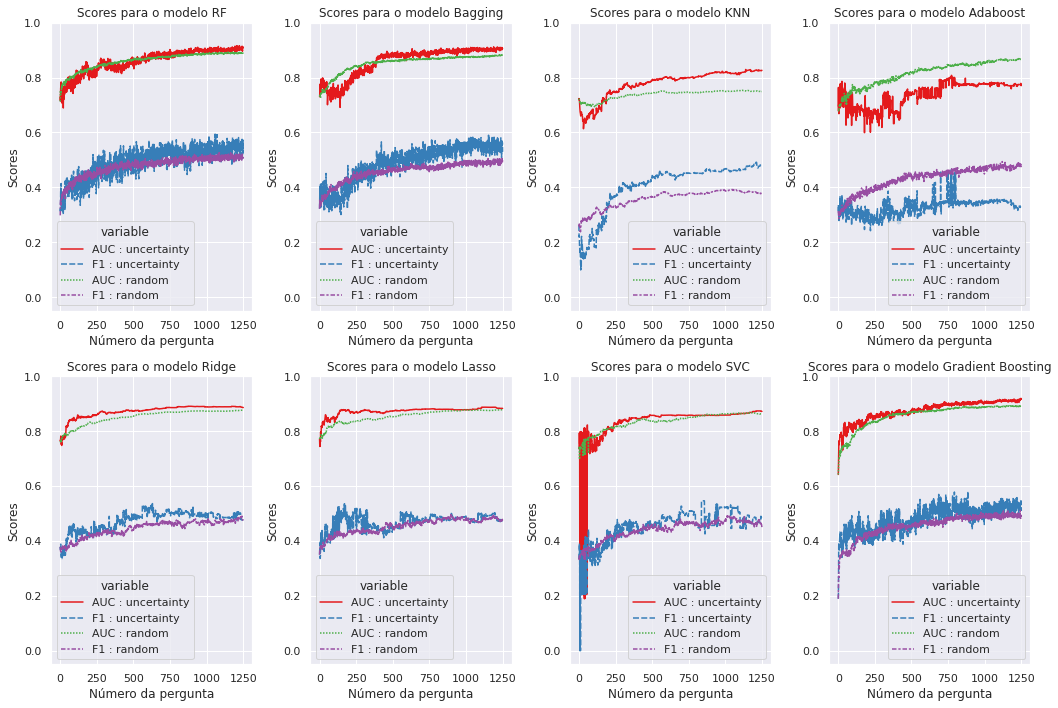

In [44]:
fig, axes = plt.subplots(2, 4, figsize = (15, 10))
tam = len(models_list)


for i in range(0,tam):
  j = i + 1
  plt.subplot(2,4,j)
  temp_data = pd.DataFrame(data = {
                            'AUC : uncertainty' : AUC_dens_info_beta1[names[i]],
                            'F1 : uncertainty': F1_dens_info_beta1[names[i]],
                            'AUC : random' : AUC_random[names[i]],
                            'F1 : random' : F1_random[names[i]],
                            'Query': np.arange(0,n_query + 1)})
  melt_data = pd.melt(temp_data, id_vars = ['Query'], 
                  value_vars = ['AUC : uncertainty', 'F1 : uncertainty', 
                                'AUC : random', 'F1 : random'])
  sns.lineplot(data = melt_data, x = "Query", y = "value", hue = "variable", style="variable") 
  plt.title("Scores para o modelo {}".format(names[i]))
  plt.xlabel("Número da pergunta")
  plt.ylabel("Scores")
  plt.ylim(-0.05, 1)

plt.tight_layout()
plt.show()

Tomando $\beta = 1.25$

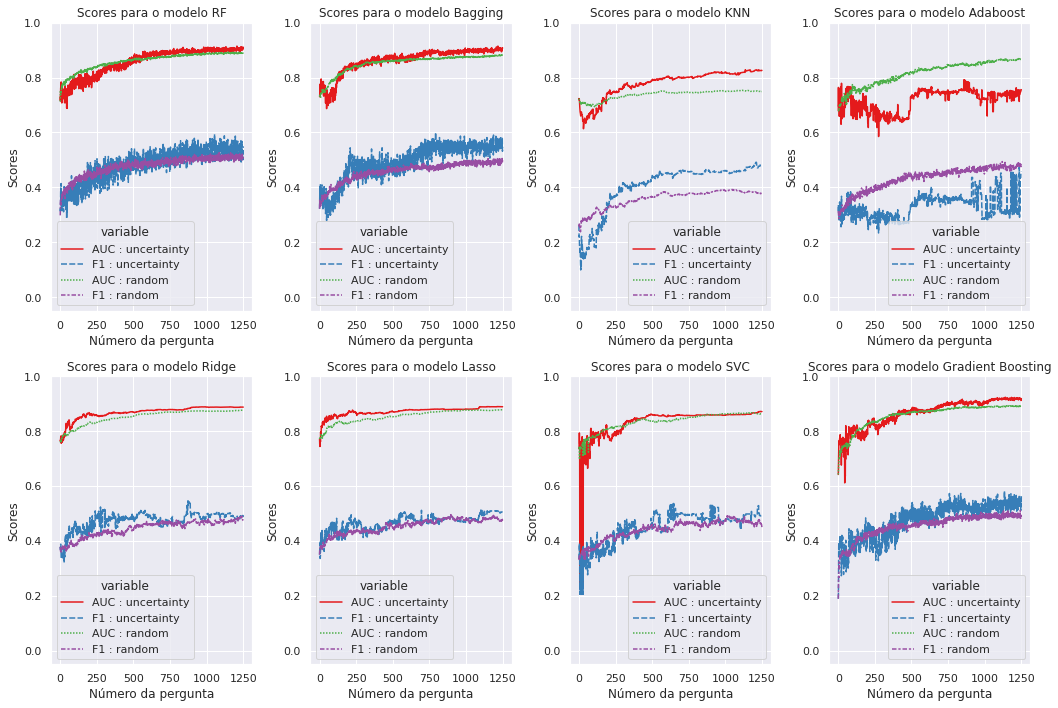

In [45]:
fig, axes = plt.subplots(2, 4, figsize = (15, 10))
tam = len(models_list)


for i in range(0,tam):
  j = i + 1
  plt.subplot(2,4,j)
  temp_data = pd.DataFrame(data = {
                            'AUC : uncertainty' : AUC_dens_info_beta1_25[names[i]],
                            'F1 : uncertainty': F1_dens_info_beta1_25[names[i]],
                            'AUC : random' : AUC_random[names[i]],
                            'F1 : random' : F1_random[names[i]],
                            'Query': np.arange(0,n_query + 1)})
  melt_data = pd.melt(temp_data, id_vars = ['Query'], 
                  value_vars = ['AUC : uncertainty', 'F1 : uncertainty', 
                                'AUC : random', 'F1 : random'])
  sns.lineplot(data = melt_data, x = "Query", y = "value", hue = "variable", style="variable") 
  plt.title("Scores para o modelo {}".format(names[i]))
  plt.xlabel("Número da pergunta")
  plt.ylabel("Scores")
  plt.ylim(-0.05, 1)

plt.tight_layout()
plt.show()

Tomando $\beta = 0.85$

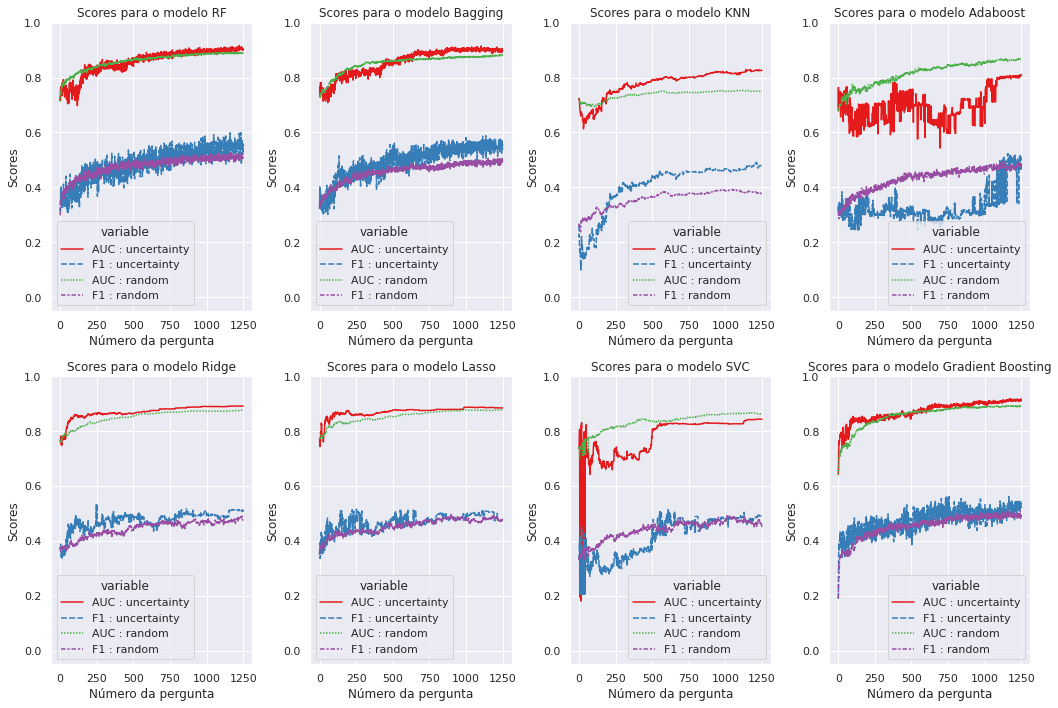

In [46]:
fig, axes = plt.subplots(2, 4, figsize = (15, 10))
tam = len(models_list)


for i in range(0,tam):
  j = i + 1
  plt.subplot(2,4,j)
  temp_data = pd.DataFrame(data = {
                            'AUC : uncertainty' : AUC_dens_info_beta0_85[names[i]],
                            'F1 : uncertainty': F1_dens_info_beta0_85[names[i]],
                            'AUC : random' : AUC_random[names[i]],
                            'F1 : random' : F1_random[names[i]],
                            'Query': np.arange(0,n_query + 1)})
  melt_data = pd.melt(temp_data, id_vars = ['Query'], 
                  value_vars = ['AUC : uncertainty', 'F1 : uncertainty', 
                                'AUC : random', 'F1 : random'])
  sns.lineplot(data = melt_data, x = "Query", y = "value", hue = "variable", style="variable") 
  plt.title("Scores para o modelo {}".format(names[i]))
  plt.xlabel("Número da pergunta")
  plt.ylabel("Scores")
  plt.ylim(-0.05, 1)

plt.tight_layout()
plt.show()